# 🎬 Humanoid Walking - MoCap Imitation (TRUE DeepMimic) - MULTI-SUBJECT

Train a humanoid to walk by **imitating motion capture data** from the CMU MoCap database.

### Data Sources (6 subjects):
| File | Subject | Description |
|------|---------|-------------|
| `02_01.amc` | Subject 2 | Normal walking |
| `05_01.amc` | Subject 5 | Normal walking |
| `06_01.amc` | Subject 6 | Normal walking |
| `07_03.amc` | Subject 7 | Walking trial 3 |
| `10_04.amc` | Subject 10 | Walking trial 4 |
| `12_01.amc` | Subject 12 | Normal walking |

### How TRUE DeepMimic Works:
```
On each episode reset:
   1. Randomly SELECT one motion clip from the library
   2. Start at a RANDOM PHASE within that clip (RSI)
   3. Robot learns to imitate THAT style for this episode
   
This teaches ROBUST walking from variety - no averaging!
```

### Key Insight:
❌ **Don't AVERAGE subjects** - creates impossible poses  
✅ **SAMPLE from subjects** - learns robust variety

### Reward Structure:
| Reward | Weight | Purpose |
|--------|--------|---------|
| **Healthy (Alive)** | 3.0 | Survival is #1 priority |
| **Forward Progress** | 2.0 | Walk at ~1.4 m/s |
| **Pose Matching** | 2.0 | Match joint angles to reference |
| **Root Position** | 1.5 | Stay upright |
| **End Effector** | 1.0 | Feet in correct positions |
| **Velocity Matching** | 0.5 | Match joint velocities |
| **Arm Swing** | 0.5 | Arms swing opposite to legs |

In [9]:
# Setup CUDA library paths for JAX GPU support
import os
import sys
import ctypes
import glob

nvidia_base = None
for path in sys.path:
    potential_nvidia = os.path.join(path, 'nvidia')
    if os.path.exists(potential_nvidia) and os.path.isdir(potential_nvidia):
        nvidia_base = potential_nvidia
        print(f"Found nvidia packages at: {nvidia_base}")
        break

if nvidia_base:
    lib_dirs = glob.glob(f"{nvidia_base}/*/lib")

    if lib_dirs:
        current_ld_path = os.environ.get('LD_LIBRARY_PATH', '')
        new_ld_path = ':'.join(lib_dirs)
        if current_ld_path:
            new_ld_path = f"{new_ld_path}:{current_ld_path}"
        os.environ['LD_LIBRARY_PATH'] = new_ld_path

        preloaded = []
        for lib_dir in lib_dirs:
            for lib_name in ['libcudart.so.12', 'libcublas.so.12', 'libcublasLt.so.12']:
                lib_path = os.path.join(lib_dir, lib_name)
                if os.path.exists(lib_path):
                    try:
                        ctypes.CDLL(lib_path, mode=ctypes.RTLD_GLOBAL)
                        preloaded.append(lib_name)
                    except Exception as e:
                        print(f"Warning loading {lib_name}: {e}")

        print(f"✓ Set LD_LIBRARY_PATH with {len(lib_dirs)} CUDA directories")
        print(f"✓ Preloaded {len(set(preloaded))} CUDA libraries")
    else:
        print(f"⚠ Found nvidia directory but no lib subdirectories")
else:
    print("⚠ Could not find nvidia CUDA packages in sys.path")

Found nvidia packages at: /usr/local/lib/python3.12/dist-packages/nvidia
✓ Set LD_LIBRARY_PATH with 17 CUDA directories
✓ Preloaded 3 CUDA libraries


In [10]:
# Check GPU availability
import jax
print("JAX version:", jax.__version__)
print("Available devices:", jax.devices())
print("Default backend:", jax.default_backend())

JAX version: 0.7.2
Available devices: [CudaDevice(id=0)]
Default backend: gpu


In [11]:
# Imports
import numpy as np
from pathlib import Path
from jax import numpy as jp
import jax.numpy as jnp
from brax import envs
from brax.io import html
from brax.training.agents.ppo import train as ppo
from brax.training.agents.ppo import networks as ppo_networks

## Step 1: Parse CMU MoCap Data

In [12]:
# Parse CMU MoCap Data (ASF/AMC files) - ALL SUBJECTS

MOCAP_DIR = Path("/content/braxphysics/RL/Training_Data")

# All available walking data files
MOCAP_FILES = [
    ("02.asf", "02_01.amc"),  # Subject 2 - normal walk
    ("05.asf", "05_01.amc"),  # Subject 5
    ("06.asf", "06_01.amc"),  # Subject 6
    ("07.asf", "07_03.amc"),  # Subject 7 (trial 3)
    ("10.asf", "10_04.amc"),  # Subject 10 (trial 4)
    ("12.asf", "12_01.amc"),  # Subject 12
]

print("="*70)
print("📄 Parsing CMU MoCap Data - MULTI-SUBJECT")
print("="*70)
print(f"Found {len(MOCAP_FILES)} walking sequences:")

class ASFParser:
    """Parse CMU ASF (Acclaim Skeleton File) format."""

    def __init__(self, filepath):
        self.bones = {}
        self.hierarchy = {}
        self.root_order = []
        self.parse(filepath)

    def parse(self, filepath):
        with open(filepath, 'r') as f:
            content = f.read()

        sections = {}
        current_section = None
        current_content = []

        for line in content.split('\n'):
            line = line.strip()
            if line.startswith(':'):
                if current_section:
                    sections[current_section] = '\n'.join(current_content)
                current_section = line[1:].split()[0]
                current_content = []
            elif current_section:
                current_content.append(line)

        if current_section:
            sections[current_section] = '\n'.join(current_content)

        if 'bonedata' in sections:
            self._parse_bones(sections['bonedata'])
        if 'hierarchy' in sections:
            self._parse_hierarchy(sections['hierarchy'])
        if 'root' in sections:
            for line in sections['root'].split('\n'):
                if line.startswith('order'):
                    self.root_order = line.split()[1:]

    def _parse_bones(self, content):
        current_bone = None
        for line in content.split('\n'):
            parts = line.split()
            if not parts:
                continue
            if parts[0] == 'begin':
                current_bone = {}
            elif parts[0] == 'end':
                if current_bone and 'name' in current_bone:
                    self.bones[current_bone['name']] = current_bone
                current_bone = None
            elif current_bone is not None:
                if parts[0] == 'name':
                    current_bone['name'] = parts[1]
                elif parts[0] == 'dof':
                    current_bone['dof'] = parts[1:]

    def _parse_hierarchy(self, content):
        for line in content.split('\n'):
            parts = line.split()
            if len(parts) >= 2 and parts[0] not in ['begin', 'end']:
                self.hierarchy[parts[0]] = parts[1:]


class AMCParser:
    """Parse CMU AMC (Acclaim Motion Capture) format."""

    def __init__(self, filepath):
        self.frames = []
        self.parse(filepath)

    def parse(self, filepath):
        with open(filepath, 'r') as f:
            lines = f.readlines()

        current_frame = None

        for line in lines:
            line = line.strip()
            if not line or line.startswith('#') or line.startswith(':'):
                continue

            parts = line.split()

            if len(parts) == 1 and parts[0].isdigit():
                if current_frame is not None:
                    self.frames.append(current_frame)
                current_frame = {'frame': int(parts[0])}
            elif current_frame is not None and len(parts) >= 2:
                bone_name = parts[0]
                values = [float(x) for x in parts[1:]]
                current_frame[bone_name] = values

        if current_frame is not None:
            self.frames.append(current_frame)


# Parse the files - ALL SUBJECTS
all_motions = []

for asf_name, amc_name in MOCAP_FILES:
    asf_file = MOCAP_DIR / asf_name
    amc_file = MOCAP_DIR / amc_name

    if not asf_file.exists() or not amc_file.exists():
        print(f"  ⚠ Skipping {amc_name} (file not found)")
        continue

    print(f"\n  📁 {amc_name}:")
    asf = ASFParser(asf_file)
    amc = AMCParser(amc_file)
    all_motions.append({
        'name': amc_name,
        'asf': asf,
        'amc': amc,
        'frames': amc.frames
    })
    print(f"     {len(amc.frames)} frames ({len(amc.frames)/120:.1f}s)")

print(f"\n✅ Loaded {len(all_motions)} walking sequences")
total_frames = sum(len(m['frames']) for m in all_motions)
print(f"   Total frames: {total_frames} ({total_frames/120:.1f} seconds)")

📄 Parsing CMU MoCap Data - MULTI-SUBJECT
Found 6 walking sequences:

  📁 02_01.amc:
     343 frames (2.9s)

  📁 05_01.amc:
     598 frames (5.0s)

  📁 06_01.amc:
     494 frames (4.1s)

  📁 07_03.amc:
     415 frames (3.5s)

  📁 10_04.amc:
     549 frames (4.6s)

  📁 12_01.amc:
     523 frames (4.4s)

✅ Loaded 6 walking sequences
   Total frames: 2922 (24.4 seconds)


## Step 2: Extract Walking Cycle & Map to Brax Joints

In [13]:
# Extract Walking Cycle & Map to Brax Humanoid Joints

print("="*70)
print("🔄 Extracting Walking Reference Motion")
print("="*70)

def extract_joint_angles(frame):
    """Extract joint angles from a single AMC frame.

    CMU MoCap coordinate system:
    - X: right (lateral)
    - Y: up (vertical)
    - Z: forward (anterior)

    Brax humanoid coordinate system:
    - X: forward
    - Y: left
    - Z: up

    We need to remap and flip signs accordingly!
    """
    pose = {}

    # Root position and rotation (CMU uses inches and degrees)
    if 'root' in frame:
        root = frame['root']
        # Position: CMU (X=right, Y=up, Z=forward) → Brax (X=forward, Y=left, Z=up)
        pose['root_x'] = root[2] * 0.0254   # CMU Z → Brax X (forward)
        pose['root_y'] = -root[0] * 0.0254  # CMU -X → Brax Y (left)
        pose['root_z'] = root[1] * 0.0254   # CMU Y → Brax Z (up)
        # Rotations also need remapping
        pose['root_rx'] = np.radians(root[5])   # CMU rz → Brax rx
        pose['root_ry'] = np.radians(-root[3])  # CMU -rx → Brax ry
        pose['root_rz'] = np.radians(root[4])   # CMU ry → Brax rz

    # Left leg - CMU femur rotations need axis swapping
    if 'lfemur' in frame:
        # CMU: (rx, ry, rz) where rx is flexion, ry is abduction, rz is rotation
        # Brax left_hip: (x=lateral, z=rotation, y=flexion)
        pose['left_hip_x'] = np.radians(-frame['lfemur'][1])  # Abduction (flip sign for left)
        pose['left_hip_z'] = np.radians(-frame['lfemur'][2])  # Rotation
        pose['left_hip_y'] = np.radians(-frame['lfemur'][0])  # Flexion (negative = forward)
    if 'ltibia' in frame:
        pose['left_knee'] = np.radians(frame['ltibia'][0])    # Knee flexion

    # Right leg
    if 'rfemur' in frame:
        pose['right_hip_x'] = np.radians(frame['rfemur'][1])  # Abduction
        pose['right_hip_z'] = np.radians(frame['rfemur'][2])  # Rotation
        pose['right_hip_y'] = np.radians(-frame['rfemur'][0]) # Flexion (negative = forward)
    if 'rtibia' in frame:
        pose['right_knee'] = np.radians(frame['rtibia'][0])   # Knee flexion

    # Spine/Torso - need to swap axes
    if 'lowerback' in frame:
        lb = frame['lowerback']
        pose['abdomen_y'] = np.radians(lb[0]) if len(lb) > 0 else 0  # Forward bend
        pose['abdomen_z'] = np.radians(lb[2]) if len(lb) > 2 else 0  # Twist
        pose['abdomen_x'] = np.radians(lb[1]) if len(lb) > 1 else 0  # Side bend

    # Left arm
    if 'lhumerus' in frame:
        lh = frame['lhumerus']
        # Shoulder: CMU (rx, ry, rz) → Brax (shoulder1=y rotation, shoulder2=x rotation)
        pose['left_shoulder1'] = np.radians(-lh[1]) if len(lh) > 1 else 0  # Arm forward/back
        pose['left_shoulder2'] = np.radians(-lh[0]) if len(lh) > 0 else 0  # Arm out/in
    if 'lradius' in frame:
        pose['left_elbow'] = np.radians(frame['lradius'][0])

    # Right arm
    if 'rhumerus' in frame:
        rh = frame['rhumerus']
        pose['right_shoulder1'] = np.radians(-rh[1]) if len(rh) > 1 else 0
        pose['right_shoulder2'] = np.radians(rh[0]) if len(rh) > 0 else 0
    if 'rradius' in frame:
        pose['right_elbow'] = np.radians(frame['rradius'][0])

    return pose


# Brax humanoid joint order (17 actuated DOFs)
BRAX_JOINTS = [
    'abdomen_y', 'abdomen_z', 'abdomen_x',
    'right_hip_x', 'right_hip_z', 'right_hip_y', 'right_knee',
    'left_hip_x', 'left_hip_z', 'left_hip_y', 'left_knee',
    'right_shoulder1', 'right_shoulder2', 'right_elbow',
    'left_shoulder1', 'left_shoulder2', 'left_elbow',
]

# Direct mapping - now using corrected joint names
CMU_TO_BRAX = {
    'abdomen_y': 0, 'abdomen_z': 1, 'abdomen_x': 2,
    'right_hip_x': 3, 'right_hip_z': 4, 'right_hip_y': 5, 'right_knee': 6,
    'left_hip_x': 7, 'left_hip_z': 8, 'left_hip_y': 9, 'left_knee': 10,
    'right_shoulder1': 11, 'right_shoulder2': 12, 'right_elbow': 13,
    'left_shoulder1': 14, 'left_shoulder2': 15, 'left_elbow': 16,
}

def frames_to_brax_reference(frames, start_frame=50, num_frames=120):
    """Convert AMC frames to Brax joint angle array."""
    reference = np.zeros((num_frames, 17))

    for i in range(num_frames):
        frame_idx = start_frame + i
        if frame_idx >= len(frames):
            frame_idx = frame_idx % len(frames)

        pose = extract_joint_angles(frames[frame_idx])

        for cmu_joint, brax_idx in CMU_TO_BRAX.items():
            if cmu_joint in pose:
                reference[i, brax_idx] = pose[cmu_joint]

    return reference


# Extract walking cycles from ALL SUBJECTS
print("\n" + "="*70)
print("🔄 Extracting Walking Cycles from All Subjects")
print("="*70)

all_references = []
cycle_frames = 120  # ~1 second at 120 FPS per subject

for motion_data in all_motions:
    frames = motion_data['frames']
    name = motion_data['name']

    # Extract multiple walking cycles from each sequence
    # Skip first 50 frames (usually settling), take cycles every 100 frames
    num_cycles = max(1, (len(frames) - 100) // 100)

    for cycle_idx in range(min(num_cycles, 5)):  # Max 5 cycles per subject
        start = 50 + cycle_idx * 100
        if start + cycle_frames > len(frames):
            break

        ref = frames_to_brax_reference(frames, start, cycle_frames)
        all_references.append(ref)
        print(f"  ✓ {name}: cycle {cycle_idx+1} (frames {start}-{start+cycle_frames})")

print(f"\n📊 Extracted {len(all_references)} walking cycles total")

# Stack all references and compute AVERAGE walking pattern
stacked_refs = np.stack(all_references, axis=0)  # (num_cycles, 120, 17)
mean_reference = np.mean(stacked_refs, axis=0)   # (120, 17) - average walk

# Also keep all cycles for variety during training
all_cycles_flat = np.concatenate(all_references, axis=0)  # (num_cycles * 120, 17)

print(f"   Mean reference shape: {mean_reference.shape}")
print(f"   All cycles shape: {all_cycles_flat.shape}")

# Resample MEAN to Brax timestep (~67 FPS, dt=0.015)
cmu_fps = 120
brax_fps = 1.0 / 0.015  # ~66.67 FPS
duration = cycle_frames / cmu_fps
brax_frames = int(duration * brax_fps)

x_cmu = np.linspace(0, 1, cycle_frames)
x_brax = np.linspace(0, 1, brax_frames)

# Create averaged reference motion
REFERENCE_MOTION = np.zeros((brax_frames, 17))
for j in range(17):
    REFERENCE_MOTION[:, j] = np.interp(x_brax, x_cmu, mean_reference[:, j])

REFERENCE_MOTION = jnp.array(REFERENCE_MOTION)

# Also create FULL reference with all cycles concatenated (for variety)
total_brax_frames = int(all_cycles_flat.shape[0] / cmu_fps * brax_fps)
x_cmu_full = np.linspace(0, 1, all_cycles_flat.shape[0])
x_brax_full = np.linspace(0, 1, total_brax_frames)

FULL_REFERENCE_MOTION = np.zeros((total_brax_frames, 17))
for j in range(17):
    FULL_REFERENCE_MOTION[:, j] = np.interp(x_brax_full, x_cmu_full, all_cycles_flat[:, j])

FULL_REFERENCE_MOTION = jnp.array(FULL_REFERENCE_MOTION)

print(f"\n✅ Reference Motions Created:")
print(f"   REFERENCE_MOTION (averaged): {REFERENCE_MOTION.shape} ({REFERENCE_MOTION.shape[0] * 0.015:.2f}s cycle)")
print(f"   FULL_REFERENCE_MOTION (all): {FULL_REFERENCE_MOTION.shape} ({FULL_REFERENCE_MOTION.shape[0] * 0.015:.2f}s total)")

# Show joint ranges from AVERAGED motion
print("\n📊 Joint angle ranges in AVERAGED walking cycle (degrees):")
for j, joint_name in enumerate(BRAX_JOINTS):
    min_val = np.degrees(float(REFERENCE_MOTION[:, j].min()))
    max_val = np.degrees(float(REFERENCE_MOTION[:, j].max()))
    range_val = max_val - min_val
    if range_val > 1:
        print(f"  {joint_name:18s}: {min_val:+6.1f}° to {max_val:+6.1f}° (range: {range_val:.1f}°)")

print(f"\n✓ REFERENCE_MOTION shape: {REFERENCE_MOTION.shape}")

🔄 Extracting Walking Reference Motion

🔄 Extracting Walking Cycles from All Subjects
  ✓ 02_01.amc: cycle 1 (frames 50-170)
  ✓ 02_01.amc: cycle 2 (frames 150-270)
  ✓ 05_01.amc: cycle 1 (frames 50-170)
  ✓ 05_01.amc: cycle 2 (frames 150-270)
  ✓ 05_01.amc: cycle 3 (frames 250-370)
  ✓ 05_01.amc: cycle 4 (frames 350-470)
  ✓ 06_01.amc: cycle 1 (frames 50-170)
  ✓ 06_01.amc: cycle 2 (frames 150-270)
  ✓ 06_01.amc: cycle 3 (frames 250-370)
  ✓ 07_03.amc: cycle 1 (frames 50-170)
  ✓ 07_03.amc: cycle 2 (frames 150-270)
  ✓ 07_03.amc: cycle 3 (frames 250-370)
  ✓ 10_04.amc: cycle 1 (frames 50-170)
  ✓ 10_04.amc: cycle 2 (frames 150-270)
  ✓ 10_04.amc: cycle 3 (frames 250-370)
  ✓ 10_04.amc: cycle 4 (frames 350-470)
  ✓ 12_01.amc: cycle 1 (frames 50-170)
  ✓ 12_01.amc: cycle 2 (frames 150-270)
  ✓ 12_01.amc: cycle 3 (frames 250-370)
  ✓ 12_01.amc: cycle 4 (frames 350-470)

📊 Extracted 20 walking cycles total
   Mean reference shape: (120, 17)
   All cycles shape: (2400, 17)

✅ Reference Moti

## Step 3: Create MoCap-Guided Environment

In [14]:
# MoCap-Guided Environment - LEGS ONLY v22 (Knee Bend Fix)

from brax.envs.base import PipelineEnv, State
from brax import math as brax_math

class MoCapHumanoidLegsOnly(PipelineEnv):
    """Humanoid walking with FIXED ARMS - only train legs.

    v22: Knee Bend Fix - Prevent "locked knee" survival strategy

    Problem: With 100M steps + 1500 episode length, agent learned to
    "game" the reward by freezing knee to avoid side lean penalty.
    Agent prioritized survival over natural motion.

    v22 Fixes:
    1. KNEE BEND REWARD during swing phase
       - Penalize straight legs (knee angle near 0) when foot is off ground
       - Force the agent to bend knees during swing phase

    2. REDUCED EPISODE LENGTH for training
       - Train with 600 steps (can test for longer)
       - Locks in correct walking style before survival optimization

    3. RELAXED PENALTIES
       - Lower side_lean_penalty (5.0) - handled by termination instead
       - Tilt termination handles extreme cases, gradient handles learning

    4. INHERITED FROM v20/v21:
       - Gyroscope upright reward
       - Death by tilt termination (~35°)
    """

    def __init__(
        self,
        reference_motion: jnp.ndarray,
        pose_reward_weight: float = 2.0,
        velocity_reward_weight: float = 0.3,
        root_reward_weight: float = 2.0,
        forward_reward_weight: float = 5.0,
        healthy_reward: float = 5.0,
        ctrl_cost_weight: float = 0.05,
        foot_skate_weight: float = 0.3,
        posture_weight: float = 15.0,
        gait_reward_weight: float = 2.0,
        lateral_penalty_weight: float = 3.0,
        height_penalty_weight: float = 8.0,
        leg_separation_weight: float = 8.0,
        hip_abduction_weight: float = 6.0,
        hip_rotation_weight: float = 8.0,
        leg_alignment_weight: float = 6.0,
        rom_reward_weight: float = 5.0,
        min_hip_y_amplitude: float = 0.3,
        min_knee_amplitude: float = 0.4,
        step_timing_weight: float = 3.0,
        foot_spacing_weight: float = 5.0,
        target_foot_spacing: float = 0.15,
        com_velocity_weight: float = 4.0,
        soft_contact_weight: float = 2.0,
        energy_penalty_weight: float = 0.01,
        upright_reward_weight: float = 5.0,       # v20 - Gyroscope reward
        max_tilt_angle: float = 0.8,              # v20 - cos(35°) ≈ 0.82, terminate below this
        knee_bend_weight: float = 4.0,            # NEW v22 - Penalize straight knees in swing
        min_swing_knee_bend: float = 0.2,         # NEW v22 - Minimum knee bend during swing (radians)
        stationary_penalty_weight: float = 8.0,
        min_velocity_threshold: float = 0.3,
        foot_separation_weight: float = 3.0,
        min_foot_separation: float = 0.10,
        terminate_when_unhealthy: bool = True,
        healthy_z_range: tuple = (0.9, 2.0),
        reset_noise_scale: float = 0.001,
        target_velocity: float = 1.0,
        target_height: float = 1.3,
        min_knee_separation: float = 0.08,
        max_knee_separation: float = 0.18,
        target_hip_x: float = 0.0,
        backend: str = 'generalized',
        **kwargs,
    ):
        from brax.io import mjcf
        from etils import epath

        path = epath.resource_path('brax') / 'envs/assets/humanoid.xml'
        sys = mjcf.load(path)

        kwargs['n_frames'] = kwargs.get('n_frames', 5)
        super().__init__(sys=sys, backend=backend, **kwargs)

        # Process reference motion - leg swap and zero abdomen
        ref_11 = reference_motion[:, :11]

        swapped_ref = jp.zeros_like(ref_11)
        swapped_ref = swapped_ref.at[:, 0:3].set(ref_11[:, 0:3])  # abdomen
        swapped_ref = swapped_ref.at[:, 3].set(-ref_11[:, 7])     # right_hip_x <- -left_hip_x
        swapped_ref = swapped_ref.at[:, 4].set(-ref_11[:, 8])     # right_hip_z <- -left_hip_z
        swapped_ref = swapped_ref.at[:, 5].set(ref_11[:, 9])      # right_hip_y <- left_hip_y
        swapped_ref = swapped_ref.at[:, 6].set(ref_11[:, 10])     # right_knee <- left_knee
        swapped_ref = swapped_ref.at[:, 7].set(-ref_11[:, 3])     # left_hip_x <- -right_hip_x
        swapped_ref = swapped_ref.at[:, 8].set(-ref_11[:, 4])     # left_hip_z <- -right_hip_z
        swapped_ref = swapped_ref.at[:, 9].set(ref_11[:, 5])      # left_hip_y <- right_hip_y
        swapped_ref = swapped_ref.at[:, 10].set(ref_11[:, 6])     # left_knee <- right_knee

        # Zero abdomen (keep upright posture)
        swapped_ref = swapped_ref.at[:, 0].set(0.0)   # abdomen_y = 0
        swapped_ref = swapped_ref.at[:, 1].set(0.0)   # abdomen_z = 0
        swapped_ref = swapped_ref.at[:, 2].set(0.0)   # abdomen_x = 0

        # Set hip_x AND hip_z to ZERO (neutral) - legs should point forward
        swapped_ref = swapped_ref.at[:, 3].set(0.0)   # right_hip_x = 0
        swapped_ref = swapped_ref.at[:, 4].set(0.0)   # right_hip_z = 0 (NO ROTATION)
        swapped_ref = swapped_ref.at[:, 7].set(0.0)   # left_hip_x = 0
        swapped_ref = swapped_ref.at[:, 8].set(0.0)   # left_hip_z = 0 (NO ROTATION)

        self._reference_motion = swapped_ref
        self._num_ref_frames = reference_motion.shape[0]
        self._cycle_duration = self._num_ref_frames * self.dt

        self._pose_reward_weight = pose_reward_weight
        self._velocity_reward_weight = velocity_reward_weight
        self._root_reward_weight = root_reward_weight
        self._forward_reward_weight = forward_reward_weight
        self._healthy_reward = healthy_reward
        self._ctrl_cost_weight = ctrl_cost_weight
        self._foot_skate_weight = foot_skate_weight
        self._posture_weight = posture_weight
        self._gait_reward_weight = gait_reward_weight
        self._lateral_penalty_weight = lateral_penalty_weight
        self._height_penalty_weight = height_penalty_weight
        self._leg_separation_weight = leg_separation_weight
        self._hip_abduction_weight = hip_abduction_weight
        self._hip_rotation_weight = hip_rotation_weight
        self._leg_alignment_weight = leg_alignment_weight
        self._rom_reward_weight = rom_reward_weight
        self._min_hip_y_amplitude = min_hip_y_amplitude
        self._min_knee_amplitude = min_knee_amplitude
        self._step_timing_weight = step_timing_weight
        self._foot_spacing_weight = foot_spacing_weight
        self._target_foot_spacing = target_foot_spacing
        self._com_velocity_weight = com_velocity_weight
        self._soft_contact_weight = soft_contact_weight
        self._energy_penalty_weight = energy_penalty_weight
        self._upright_reward_weight = upright_reward_weight
        self._max_tilt_angle = max_tilt_angle
        self._knee_bend_weight = knee_bend_weight
        self._min_swing_knee_bend = min_swing_knee_bend
        self._stationary_penalty_weight = stationary_penalty_weight
        self._min_velocity_threshold = min_velocity_threshold
        self._foot_separation_weight = foot_separation_weight
        self._min_foot_separation = min_foot_separation
        self._terminate_when_unhealthy = terminate_when_unhealthy
        self._healthy_z_range = healthy_z_range
        self._reset_noise_scale = reset_noise_scale
        self._target_velocity = target_velocity
        self._target_height = target_height
        self._min_knee_separation = min_knee_separation
        self._max_knee_separation = max_knee_separation
        self._target_hip_x = target_hip_x

        # Body indices
        self._torso_idx = 0
        self._right_thigh_idx = 3
        self._left_thigh_idx = 6
        self._right_shin_idx = 4
        self._left_shin_idx = 7
        self._right_foot_idx = 5
        self._left_foot_idx = 8

        # Fixed arms at sides
        self._fixed_arm_positions = jp.array([0.0, 0.0, 0.0, 0.0, 0.0, 0.0])

        # Joint weights - balanced for natural motion
        self._joint_weights = jp.array([
            0.5, 0.3, 0.3,       # abdomen
            0.2, 0.8, 2.0, 1.5,  # right leg: hip_x LOW, hip_z MED, hip_y HIGH, knee HIGH
            0.2, 0.8, 2.0, 1.5,  # left leg: same
        ])

    def reset(self, rng: jax.Array) -> State:
        rng, rng1, rng2, rng3 = jax.random.split(rng, 4)
        qpos = self.sys.init_q.copy()

        init_phase = jax.random.uniform(rng3, minval=0.0, maxval=1.0)
        frame_idx = (init_phase * self._num_ref_frames).astype(jp.int32)
        frame_idx = jp.clip(frame_idx, 0, self._num_ref_frames - 1)
        ref_pose = self._reference_motion[frame_idx]

        qpos = qpos.at[7:18].set(ref_pose[:11])
        qpos = qpos.at[18:24].set(self._fixed_arm_positions)

        low, hi = -self._reset_noise_scale, self._reset_noise_scale
        leg_noise = jax.random.uniform(rng1, (11,), minval=low, maxval=hi)
        qpos = qpos.at[7:18].add(leg_noise)

        qvel = jax.random.uniform(rng2, (self.sys.qd_size(),), minval=low, maxval=hi)
        qvel = qvel.at[17:23].set(0.0)

        pipeline_state = self.pipeline_init(qpos, qvel)
        obs = self._get_obs(pipeline_state, init_phase)

        reward, done, zero = jp.zeros(3)
        metrics = {
            'pose_reward': zero,
            'velocity_reward': zero,
            'root_reward': zero,
            'forward_reward': zero,
            'posture_reward': zero,
            'gait_reward': zero,
            'lateral_penalty': zero,
            'height_penalty': zero,
            'knee_separation_reward': zero,
            'hip_abduction_reward': zero,
            'hip_rotation_penalty': zero,
            'leg_alignment_penalty': zero,
            'rom_reward': zero,
            'step_timing_reward': zero,
            'foot_spacing_reward': zero,
            'com_velocity_reward': zero,
            'soft_contact_reward': zero,
            'energy_penalty': zero,
            'upright_reward': zero,               # v20
            'torso_uprightness': 1.0,             # v20 - track actual value
            'knee_bend_reward': zero,             # NEW v22
            'foot_separation_penalty': zero,
            'stationary_penalty': zero,
            'reward_alive': zero,
            'reward_ctrl': zero,
            'foot_skate_penalty': zero,
            'x_velocity': zero,
            'y_drift': zero,
            'height': zero,
            'phase': init_phase,
            'step_count': zero,
        }

        return State(pipeline_state, obs, reward, done, metrics)

    def _compute_torso_uprightness(self, pipeline_state) -> jax.Array:
        """Compute how upright the torso is relative to world Z-axis.

        Returns value in [0, 1] where:
        - 1.0 = perfectly upright (torso Z points to sky)
        - 0.0 = completely horizontal (torso Z perpendicular to sky)

        This is the GYROSCOPE fix - absolute world reference, ignores MoCap.
        """
        # Get torso quaternion (w, x, y, z format in Brax)
        torso_quat = pipeline_state.x.rot[self._torso_idx]

        # Local up vector [0, 0, 1] - the direction the torso's "head" points
        local_up = jp.array([0.0, 0.0, 1.0])

        # Rotate local up vector by torso quaternion to get world-space up vector
        # Using brax's quaternion rotation
        world_up = brax_math.rotate(local_up, torso_quat)

        # The Z component tells us how aligned with world up [0,0,1] we are
        # world_up[2] = 1.0 means perfectly upright
        # world_up[2] = 0.0 means horizontal
        # world_up[2] < 0 means upside down
        uprightness = world_up[2]

        return uprightness

    def step(self, state: State, action: jax.Array) -> State:
        step_count = state.metrics['step_count'] + 1
        phase = (step_count * self.dt / self._cycle_duration) % 1.0
        frame_idx = (phase * self._num_ref_frames).astype(jp.int32)
        frame_idx = jp.clip(frame_idx, 0, self._num_ref_frames - 1)

        ref_pose = self._reference_motion[frame_idx]

        # Scale leg actions
        action_min = self.sys.actuator.ctrl_range[:11, 0]
        action_max = self.sys.actuator.ctrl_range[:11, 1]
        leg_action = (action[:11] + 1) * (action_max - action_min) * 0.5 + action_min

        arm_action = self._fixed_arm_positions
        full_action = jp.concatenate([leg_action, arm_action])

        pipeline_state0 = state.pipeline_state
        pipeline_state = self.pipeline_step(pipeline_state0, full_action)

        # ====== REWARDS ======
        body_pos = pipeline_state.x.pos
        torso_z = body_pos[self._torso_idx, 2]
        torso_y = body_pos[self._torso_idx, 1]

        current_leg_joints = pipeline_state.q[7:18]

        # ====== NEW v20: GYROSCOPE UPRIGHT REWARD ======
        # This is THE key fix for torso tilting
        torso_uprightness = self._compute_torso_uprightness(pipeline_state)

        # Tilt = how far from perfectly upright (1.0)
        tilt = 1.0 - torso_uprightness

        # Sharp exponential penalty for any tilt - "chest pointing at sky"
        upright_reward = self._upright_reward_weight * jp.exp(-20.0 * tilt)

        # ====== END NEW v20 ======

        # 1. POSE REWARD
        joint_diff = current_leg_joints - ref_pose
        joint_error = jp.sum(self._joint_weights * jp.square(joint_diff))
        pose_reward = self._pose_reward_weight * jp.exp(-2.0 * joint_error)

        # 2. VELOCITY REWARD
        next_idx = (frame_idx + 1) % self._num_ref_frames
        ref_pose_next = self._reference_motion[next_idx]
        ref_velocity = (ref_pose_next - ref_pose) / self.dt
        current_velocity = pipeline_state.qd[6:17]
        vel_diff = current_velocity - ref_velocity
        vel_error = jp.sum(self._joint_weights * jp.square(vel_diff))
        velocity_reward = self._velocity_reward_weight * jp.exp(-0.1 * vel_error)

        # 3. ROOT REWARD - penalize lateral drift
        root_reward = self._root_reward_weight * jp.exp(-10.0 * jp.square(torso_y))

        # 4. POSTURE REWARD - quaternion-based (supplementary to gyroscope)
        torso_rot = pipeline_state.x.rot[self._torso_idx]
        upright_error = 1.0 - jp.square(torso_rot[0])
        forward_lean_penalty = 12.0 * jp.square(torso_rot[1])
        side_lean_penalty = 5.0 * jp.square(torso_rot[2])
        twist_penalty = 3.0 * jp.square(torso_rot[3])

        abdomen_y = current_leg_joints[0]
        abdomen_z = current_leg_joints[1]
        abdomen_x = current_leg_joints[2]
        abdomen_penalty = 15.0 * jp.square(abdomen_y) + 3.0 * jp.square(abdomen_z) + 8.0 * jp.square(abdomen_x)

        posture_reward = self._posture_weight * jp.exp(-2.0 * (
            upright_error + forward_lean_penalty + side_lean_penalty + twist_penalty + abdomen_penalty
        ))

        # 5. FORWARD REWARD
        com_before = self._com(pipeline_state0)
        com_after = self._com(pipeline_state)
        x_velocity = (com_after[0] - com_before[0]) / self.dt
        y_velocity = (com_after[1] - com_before[1]) / self.dt
        z_velocity = (com_after[2] - com_before[2]) / self.dt

        vel_error = jp.abs(x_velocity - self._target_velocity)
        forward_reward = self._forward_reward_weight * jp.exp(-vel_error**2 / 0.3)
        forward_bonus = jp.where(x_velocity > 0.5, 1.0, 0.0)
        forward_reward = forward_reward + forward_bonus

        # 6. CoM VELOCITY TRACKING
        com_vel_error = jp.square(y_velocity) + 0.5 * jp.square(z_velocity)
        com_velocity_reward = self._com_velocity_weight * jp.exp(-5.0 * com_vel_error)

        # 7. STATIONARY PENALTY
        too_slow = jp.where(x_velocity < self._min_velocity_threshold,
                           jp.square(self._min_velocity_threshold - x_velocity), 0.0)
        backwards_penalty = jp.where(x_velocity < 0.0, jp.square(x_velocity) * 2.0, 0.0)
        stationary_penalty = self._stationary_penalty_weight * (too_slow + backwards_penalty)

        # 8. LATERAL DRIFT PENALTY
        lateral_penalty = self._lateral_penalty_weight * (
            jp.square(torso_y) + jp.square(y_velocity)
        )

        # 9. HEIGHT PENALTY
        height_error = jp.square(torso_z - self._target_height)
        height_penalty = self._height_penalty_weight * height_error

        # 10. KNEE SEPARATION (lateral - Y axis)
        right_shin_y = body_pos[self._right_shin_idx, 1]
        left_shin_y = body_pos[self._left_shin_idx, 1]
        knee_separation = left_shin_y - right_shin_y

        too_close = jp.where(knee_separation < self._min_knee_separation,
                             jp.square(self._min_knee_separation - knee_separation), 0.0)
        too_far = jp.where(knee_separation > self._max_knee_separation,
                           jp.square(knee_separation - self._max_knee_separation), 0.0)
        knee_separation_reward = self._leg_separation_weight * jp.exp(-20.0 * (too_close + too_far))

        # 11. HIP ABDUCTION (hip_x - lateral spread)
        right_hip_x = current_leg_joints[3]
        left_hip_x = current_leg_joints[7]
        right_hip_x_error = jp.square(right_hip_x)
        left_hip_x_error = jp.square(left_hip_x)
        hip_abduction_reward = self._hip_abduction_weight * jp.exp(-4.0 * (right_hip_x_error + left_hip_x_error))

        # 12. HIP ROTATION PENALTY
        right_hip_z = current_leg_joints[4]
        left_hip_z = current_leg_joints[8]
        hip_rotation_error = jp.square(right_hip_z) + jp.square(left_hip_z)
        hip_rotation_penalty = self._hip_rotation_weight * hip_rotation_error

        # 13. LEG ALIGNMENT PENALTY
        right_thigh_y = body_pos[self._right_thigh_idx, 1]
        left_thigh_y = body_pos[self._left_thigh_idx, 1]
        right_alignment_error = jp.square(right_shin_y - right_thigh_y)
        left_alignment_error = jp.square(left_shin_y - left_thigh_y)
        leg_alignment_penalty = self._leg_alignment_weight * (right_alignment_error + left_alignment_error)

        # 14. RANGE OF MOTION REWARD
        right_hip_y = current_leg_joints[5]
        left_hip_y = current_leg_joints[9]
        right_knee = current_leg_joints[6]
        left_knee = current_leg_joints[10]

        hip_y_diff = jp.abs(right_hip_y - left_hip_y)
        knee_diff = jp.abs(right_knee - left_knee)

        hip_y_rom_reward = jp.where(hip_y_diff > self._min_hip_y_amplitude,
                                     1.0,
                                     hip_y_diff / self._min_hip_y_amplitude)

        knee_rom_reward = jp.where(knee_diff > self._min_knee_amplitude,
                                    1.0,
                                    knee_diff / self._min_knee_amplitude)

        right_knee_bend = jp.abs(right_knee)
        left_knee_bend = jp.abs(left_knee)
        max_knee_bend = jp.maximum(right_knee_bend, left_knee_bend)
        knee_bend_reward = jp.where(max_knee_bend > 0.3, 1.0, max_knee_bend / 0.3)

        rom_reward = self._rom_reward_weight * (
            0.4 * hip_y_rom_reward + 0.4 * knee_rom_reward + 0.2 * knee_bend_reward
        )

        # 15. STEP TIMING REWARD
        left_foot_z = body_pos[self._left_foot_idx, 2]
        right_foot_z = body_pos[self._right_foot_idx, 2]

        left_swing_height = jp.maximum(0.0, left_foot_z - 0.05)
        right_swing_height = jp.maximum(0.0, right_foot_z - 0.05)

        timing_symmetry = jp.abs(left_swing_height - right_swing_height)
        both_up_penalty = left_swing_height * right_swing_height
        both_down_bonus = jp.where((left_foot_z < 0.08) | (right_foot_z < 0.08), 0.3, 0.0)

        step_timing_reward = self._step_timing_weight * (
            0.5 * jp.exp(-5.0 * both_up_penalty) + 0.3 * timing_symmetry + 0.2 * both_down_bonus
        )

        # 16. FOOT LATERAL SPACING REWARD
        right_foot_y = body_pos[self._right_foot_idx, 1]
        left_foot_y = body_pos[self._left_foot_idx, 1]
        foot_lateral_spacing = left_foot_y - right_foot_y

        spacing_error = jp.abs(foot_lateral_spacing - self._target_foot_spacing)
        foot_spacing_reward = self._foot_spacing_weight * jp.exp(-10.0 * jp.square(spacing_error))

        # 17. SOFT CONTACT REWARD - prevent stomping
        foot_vel = pipeline_state.xd.vel

        left_foot_vel_mag = jp.sqrt(
            jp.square(foot_vel[self._left_foot_idx, 0]) +
            jp.square(foot_vel[self._left_foot_idx, 1]) +
            jp.square(foot_vel[self._left_foot_idx, 2])
        )
        right_foot_vel_mag = jp.sqrt(
            jp.square(foot_vel[self._right_foot_idx, 0]) +
            jp.square(foot_vel[self._right_foot_idx, 1]) +
            jp.square(foot_vel[self._right_foot_idx, 2])
        )

        left_contact = jp.where(left_foot_z < 0.08, 1.0, 0.0)
        right_contact = jp.where(right_foot_z < 0.08, 1.0, 0.0)

        left_soft_landing = jp.exp(-2.0 * left_foot_vel_mag)
        right_soft_landing = jp.exp(-2.0 * right_foot_vel_mag)

        soft_contact_reward = self._soft_contact_weight * (
            left_contact * left_soft_landing + right_contact * right_soft_landing
        )

        # 18. FOOT SEPARATION PENALTY
        feet_too_close = jp.where(foot_lateral_spacing < self._min_foot_separation,
                                   jp.square(self._min_foot_separation - foot_lateral_spacing), 0.0)
        foot_separation_penalty = self._foot_separation_weight * feet_too_close

        # 19. GAIT REWARD
        expected_right_down = jp.where(phase < 0.5, 1.0, 0.0)
        expected_left_down = jp.where(phase >= 0.5, 1.0, 0.0)

        right_correct = expected_right_down * right_contact + (1 - expected_right_down) * (1 - right_contact)
        left_correct = expected_left_down * left_contact + (1 - expected_left_down) * (1 - left_contact)

        both_down = right_contact * left_contact
        both_up = (1 - right_contact) * (1 - left_contact)
        gallop_penalty = both_down + both_up

        gait_reward = self._gait_reward_weight * (
            0.5 * (right_correct + left_correct) - 0.5 * gallop_penalty
        )

        # 20. FOOT SKATE PENALTY
        left_foot_vel_h = jp.sqrt(jp.square(foot_vel[self._left_foot_idx, 0]) +
                                   jp.square(foot_vel[self._left_foot_idx, 1]))
        right_foot_vel_h = jp.sqrt(jp.square(foot_vel[self._right_foot_idx, 0]) +
                                    jp.square(foot_vel[self._right_foot_idx, 1]))

        foot_skate_penalty = self._foot_skate_weight * (
            left_contact * left_foot_vel_h + right_contact * right_foot_vel_h
        )

        # 21. CONTROL COST
        ctrl_cost = self._ctrl_cost_weight * jp.sum(jp.square(leg_action))

        # 22. ENERGY PENALTY
        energy_penalty = self._energy_penalty_weight * jp.sum(jp.abs(leg_action))

        # ====== NEW v22: KNEE BEND REWARD DURING SWING PHASE ======
        # Penalize straight knees when foot is off the ground (swing phase)
        # This prevents the "locked knee" survival strategy

        # Detect swing phase (foot off ground)
        left_in_swing = jp.where(left_foot_z > 0.08, 1.0, 0.0)
        right_in_swing = jp.where(right_foot_z > 0.08, 1.0, 0.0)

        # Get knee angles (negative values = bent)
        right_knee_angle = jp.abs(right_knee)
        left_knee_angle = jp.abs(left_knee)

        # Penalize if knee is too straight during swing
        right_knee_too_straight = jp.where(right_knee_angle < self._min_swing_knee_bend,
                                            self._min_swing_knee_bend - right_knee_angle, 0.0)
        left_knee_too_straight = jp.where(left_knee_angle < self._min_swing_knee_bend,
                                           self._min_swing_knee_bend - left_knee_angle, 0.0)

        # Only apply penalty during swing phase
        knee_straight_penalty = (
            right_in_swing * jp.square(right_knee_too_straight) +
            left_in_swing * jp.square(left_knee_too_straight)
        )

        # Reward for proper knee bend during swing
        right_bend_bonus = right_in_swing * jp.minimum(right_knee_angle / 0.4, 1.0)
        left_bend_bonus = left_in_swing * jp.minimum(left_knee_angle / 0.4, 1.0)

        knee_bend_reward = self._knee_bend_weight * (
            0.5 * (right_bend_bonus + left_bend_bonus) - knee_straight_penalty
        )
        # ====== END NEW v22 ======

        # ====== HEALTH CHECK with DEATH BY TILT (v20) ======
        min_z, max_z = self._healthy_z_range

        # Height check (existing)
        is_fallen = jp.where(torso_z < min_z, 1.0, 0.0)
        is_too_high = jp.where(torso_z > max_z, 1.0, 0.0)

        # NEW v20: DEATH BY TILT - terminate if tilted > ~35 degrees
        # torso_uprightness < 0.8 means tilt > ~35 degrees (cos(35°) ≈ 0.82)
        is_tilted = jp.where(torso_uprightness < self._max_tilt_angle, 1.0, 0.0)

        # Combined health check
        is_unhealthy = jp.maximum(jp.maximum(is_fallen, is_too_high), is_tilted)
        is_healthy = 1.0 - is_unhealthy

        healthy_reward = self._healthy_reward * is_healthy

        # TOTAL REWARD (added upright_reward and knee_bend_reward)
        reward = (
            pose_reward + velocity_reward + root_reward + forward_reward +
            posture_reward + gait_reward + knee_separation_reward + hip_abduction_reward +
            rom_reward + step_timing_reward + foot_spacing_reward +
            com_velocity_reward + soft_contact_reward + upright_reward + knee_bend_reward + healthy_reward
            - ctrl_cost - foot_skate_penalty - lateral_penalty - height_penalty
            - stationary_penalty - foot_separation_penalty
            - hip_rotation_penalty - leg_alignment_penalty - energy_penalty
        )

        done = is_unhealthy if self._terminate_when_unhealthy else 0.0

        obs = self._get_obs(pipeline_state, phase)

        state.metrics.update(
            pose_reward=pose_reward,
            velocity_reward=velocity_reward,
            root_reward=root_reward,
            forward_reward=forward_reward,
            posture_reward=posture_reward,
            gait_reward=gait_reward,
            lateral_penalty=lateral_penalty,
            height_penalty=height_penalty,
            knee_separation_reward=knee_separation_reward,
            hip_abduction_reward=hip_abduction_reward,
            hip_rotation_penalty=hip_rotation_penalty,
            leg_alignment_penalty=leg_alignment_penalty,
            rom_reward=rom_reward,
            step_timing_reward=step_timing_reward,
            foot_spacing_reward=foot_spacing_reward,
            com_velocity_reward=com_velocity_reward,
            soft_contact_reward=soft_contact_reward,
            energy_penalty=energy_penalty,
            upright_reward=upright_reward,
            torso_uprightness=torso_uprightness,
            knee_bend_reward=knee_bend_reward,
            foot_separation_penalty=foot_separation_penalty,
            stationary_penalty=stationary_penalty,
            reward_alive=healthy_reward,
            reward_ctrl=-ctrl_cost,
            foot_skate_penalty=foot_skate_penalty,
            x_velocity=x_velocity,
            y_drift=torso_y,
            height=torso_z,
            phase=phase,
            step_count=step_count,
        )

        return state.replace(
            pipeline_state=pipeline_state, obs=obs, reward=reward, done=done
        )

    def _get_obs(self, pipeline_state, phase) -> jax.Array:
        """Observation includes phase signal (sin/cos) for time awareness."""
        position = pipeline_state.q[2:18]
        velocity = pipeline_state.qd[:17]

        # Phase signal
        phase_sin = jp.sin(2 * jp.pi * phase)
        phase_cos = jp.cos(2 * jp.pi * phase)

        frame_idx = (phase * self._num_ref_frames).astype(jp.int32)
        frame_idx = jp.clip(frame_idx, 0, self._num_ref_frames - 1)
        ref_pose = self._reference_motion[frame_idx]

        return jp.concatenate([position, velocity, jp.array([phase_sin, phase_cos]), ref_pose])

    def _com(self, pipeline_state) -> jax.Array:
        """Calculate Center of Mass position."""
        inertia = self.sys.link.inertia
        mass_sum = jp.sum(inertia.mass)
        x_i = pipeline_state.x.vmap().do(inertia.transform)
        com = jp.sum(jax.vmap(jp.multiply)(inertia.mass, x_i.pos), axis=0) / mass_sum
        return com

    @property
    def action_size(self) -> int:
        return 11


# ====== CREATE ENVIRONMENT v22 ======
print("="*70)
print("🎯 Creating MoCap Environment v22 - KNEE BEND FIX")
print("="*70)

print(f"\\n📊 Using averaged reference motion: {REFERENCE_MOTION.shape}")

mocap_env = MoCapHumanoidLegsOnly(
    reference_motion=REFERENCE_MOTION,
    pose_reward_weight=2.0,
    velocity_reward_weight=0.3,
    root_reward_weight=2.0,
    forward_reward_weight=5.0,
    posture_weight=15.0,
    gait_reward_weight=2.0,
    lateral_penalty_weight=3.0,
    height_penalty_weight=8.0,
    leg_separation_weight=8.0,
    hip_abduction_weight=6.0,
    hip_rotation_weight=8.0,
    leg_alignment_weight=6.0,
    rom_reward_weight=5.0,
    min_hip_y_amplitude=0.3,
    min_knee_amplitude=0.4,
    step_timing_weight=3.0,
    foot_spacing_weight=5.0,
    target_foot_spacing=0.15,
    com_velocity_weight=4.0,
    soft_contact_weight=2.0,
    energy_penalty_weight=0.01,
    upright_reward_weight=5.0,           # v20 - Gyroscope reward
    max_tilt_angle=0.8,                  # v20 - cos(35°), terminate if below
    knee_bend_weight=4.0,                # NEW v22 - Penalize straight knees in swing
    min_swing_knee_bend=0.2,             # NEW v22 - Minimum knee bend during swing (radians)
    stationary_penalty_weight=8.0,
    min_velocity_threshold=0.3,
    foot_separation_weight=3.0,
    min_foot_separation=0.10,
    healthy_reward=5.0,
    ctrl_cost_weight=0.05,
    foot_skate_weight=0.3,
    target_velocity=1.0,
    target_height=1.3,
    min_knee_separation=0.08,
    max_knee_separation=0.18,
    target_hip_x=0.0,
    healthy_z_range=(0.9, 2.0),
    reset_noise_scale=0.001,
    backend='generalized'
)

print(f"\\n✅ MoCapHumanoidLegsOnly v22 Created!")
print(f"   Observation size: {mocap_env.observation_size}")
print(f"   Action size: {mocap_env.action_size}")
print(f"\\n   🎯 v22 KNEE BEND FIX:")
print(f"   ")
print(f"   🦵 FIX #1: KNEE BEND REWARD (NEW)")
print(f"   ✓ knee_bend_weight: 4.0")
print(f"   ✓ Penalizes straight knees during swing phase")
print(f"   ✓ min_swing_knee_bend: 0.2 radians (~11°)")
print(f"   ✓ Prevents 'locked knee' survival strategy")
print(f"   ")
print(f"   🔧 INHERITED FROM v20/v21:")
print(f"   ✓ Gyroscope upright reward (5.0 weight)")
print(f"   ✓ Death by tilt termination (~35°)")
print(f"   ")
print(f"   📊 New Metrics:")
print(f"   ✓ knee_bend_reward - tracks swing phase knee bending")

envs._envs['mocap_humanoid_legs'] = MoCapHumanoidLegsOnly

🎯 Creating MoCap Environment v22 - KNEE BEND FIX
\n📊 Using averaged reference motion: (66, 17)


/usr/local/lib/python3.12/dist-packages/brax/io/mjcf.py:480: UserWarning: Brax System, piplines and environments are not actively being maintained. Please see MJX for a well maintained JAX-based physics engine: https://github.com/google-deepmind/mujoco/tree/main/mjx. For a host of environments that use MJX, see: https://github.com/google-deepmind/mujoco_playground.
  warnings.warn(


\n✅ MoCapHumanoidLegsOnly v22 Created!
   Observation size: 46
   Action size: 11
\n   🎯 v22 KNEE BEND FIX:
   
   🦵 FIX #1: KNEE BEND REWARD (NEW)
   ✓ knee_bend_weight: 4.0
   ✓ Penalizes straight knees during swing phase
   ✓ min_swing_knee_bend: 0.2 radians (~11°)
   ✓ Prevents 'locked knee' survival strategy
   
   🔧 INHERITED FROM v20/v21:
   ✓ Gyroscope upright reward (5.0 weight)
   ✓ Death by tilt termination (~35°)
   
   📊 New Metrics:
   ✓ knee_bend_reward - tracks swing phase knee bending


## Step 4: Train with MoCap Reference

In [15]:
# Train with MoCap Reference - LEGS ONLY v22 (Knee Bend Fix)

print("="*70)
print("🎯 Training MoCap Walking v22 - KNEE BEND FIX (30M steps)")
print("="*70)
print("\\n🎯 v22 Key Fixes for Locked Knee:")
print("  🦵 FIX #1: KNEE BEND REWARD")
print("  ✓ Penalizes straight knees during swing phase")
print("  ✓ knee_bend_weight: 4.0")
print("  ✓ Forces agent to bend knees when foot is off ground")
print("  ")
print("  📊 TRAINING (same as v20):")
print("  ✓ num_timesteps: 30M")
print("  ✓ episode_length: 500")
print("  ✓ num_evals: 20")
print("  ")
print("  🔧 INHERITED FROM v20:")
print("  ✓ Gyroscope upright reward")
print("  ✓ Death by tilt termination")
print("\\n" + "="*70)

def make_legs_networks(obs_shape, action_size, preprocess_observations_fn=lambda x: x):
    return ppo_networks.make_ppo_networks(
        obs_shape, action_size,
        preprocess_observations_fn=preprocess_observations_fn,
        policy_hidden_layer_sizes=(256, 256),
        value_hidden_layer_sizes=(256, 256),
    )

print("\\n⏳ Training started... (~15-25 min for 30M steps)")
print("   v22: Knee Bend Fix - 30M steps, episode_length=500!\\n")

legs_train_fn = lambda: ppo.train(
    environment=mocap_env,
    num_timesteps=30_000_000,
    num_evals=20,
    reward_scaling=0.1,
    episode_length=500,
    normalize_observations=True,
    action_repeat=1,
    unroll_length=10,
    num_minibatches=32,
    num_updates_per_batch=4,
    discounting=0.99,
    learning_rate=3e-4,
    entropy_cost=0.01,
    num_envs=512,
    batch_size=256,
    network_factory=make_legs_networks,
)

# Actually RUN the training!
mocap_inference_fn, mocap_params, mocap_metrics = legs_train_fn()

print("\\n" + "="*70)
print("✅ v22 Knee Bend Training Complete!")

🎯 Training MoCap Walking v22 - KNEE BEND FIX (30M steps)
\n🎯 v22 Key Fixes for Locked Knee:
  🦵 FIX #1: KNEE BEND REWARD
  ✓ Penalizes straight knees during swing phase
  ✓ knee_bend_weight: 4.0
  ✓ Forces agent to bend knees when foot is off ground
  
  📊 TRAINING (same as v20):
  ✓ num_timesteps: 30M
  ✓ episode_length: 500
  ✓ num_evals: 20
  
  🔧 INHERITED FROM v20:
  ✓ Gyroscope upright reward
  ✓ Death by tilt termination
\n======================================================================
\n⏳ Training started... (~15-25 min for 30M steps)
   v22: Knee Bend Fix - 30M steps, episode_length=500!\n
\n======================================================================
✅ v22 Knee Bend Training Complete!


## Step 5: Visualize Results

In [16]:
# Visualize LEGS ONLY Walking v22 - Knee Bend Fix

print("="*70)
print("🎯 Visualizing Legs-Only Walking v22 - Knee Bend Fix")
print("="*70)

mocap_eval_env = MoCapHumanoidLegsOnly(
    reference_motion=REFERENCE_MOTION,
    target_velocity=1.0,
    healthy_z_range=(0.8, 2.0),
    backend='generalized'
)

mocap_policy = mocap_inference_fn(mocap_params, deterministic=True)
jit_mocap_reset = jax.jit(mocap_eval_env.reset)
jit_mocap_step = jax.jit(mocap_eval_env.step)
jit_mocap_policy = jax.jit(mocap_policy)

rng = jax.random.PRNGKey(0)
state = jit_mocap_reset(rng)
states = []

VERSION = "v23"
episode_length = 1000  # Test for longer than training (600)
record_every = 2

print(f"Running {episode_length} steps ({episode_length * 0.015:.1f} seconds)...")
print(f"Arms are FIXED at sides - only legs move")

velocities = []
for step in range(episode_length):
    if step % 100 == 0:
        phase = float(state.metrics['phase'])
        x_vel = float(state.metrics['x_velocity'])
        torso_z = float(state.pipeline_state.x.pos[0, 2])
        print(f"  Step {step}, Phase: {phase:.2f}, Vel: {x_vel:.2f} m/s, Height: {torso_z:.2f}m")

    rng, key = jax.random.split(rng)
    act, _ = jit_mocap_policy(state.obs, key)
    state = jit_mocap_step(state, act)

    velocities.append(float(state.metrics['x_velocity']))

    if step % record_every == 0:
        states.append(state.pipeline_state)

    if state.done:
        print(f"  ⚠ Episode ended at step {step} (robot fell)")
        break

if not state.done:
    print(f"  ✅ Robot stayed upright for full {episode_length} steps!")

avg_velocity = np.mean(velocities)
print(f"\n📊 Average velocity: {avg_velocity:.2f} m/s")
print(f"✓ Collected {len(states)} frames")

# Save visualization
print("\nRendering HTML...")
output_path = f"/content/braxphysics/RL/Results/humanoid_legs_only_{VERSION}.html"
html_content = html.render(mocap_eval_env.sys, states)

with open(output_path, "w") as f:
    f.write(html_content)

print(f"✓ Saved: {output_path}")
print(f"\n🎉 Open humanoid_legs_only_{VERSION}.html in a browser!")

🎯 Visualizing Legs-Only Walking v22 - Knee Bend Fix
Running 1000 steps (15.0 seconds)...
Arms are FIXED at sides - only legs move
  Step 0, Phase: 0.27, Vel: 0.00 m/s, Height: 1.40m
  Step 100, Phase: 0.52, Vel: 0.77 m/s, Height: 1.18m
  Step 200, Phase: 0.03, Vel: 0.87 m/s, Height: 1.19m
  Step 300, Phase: 0.55, Vel: 0.97 m/s, Height: 1.19m
  Step 400, Phase: 0.06, Vel: 1.03 m/s, Height: 1.17m
  Step 500, Phase: 0.58, Vel: 0.81 m/s, Height: 1.18m
  Step 600, Phase: 0.09, Vel: 0.85 m/s, Height: 1.19m
  Step 700, Phase: 0.61, Vel: 0.90 m/s, Height: 1.19m
  Step 800, Phase: 0.12, Vel: 1.04 m/s, Height: 1.18m
  Step 900, Phase: 0.64, Vel: 0.83 m/s, Height: 1.18m
  ✅ Robot stayed upright for full 1000 steps!

📊 Average velocity: 0.88 m/s
✓ Collected 500 frames

Rendering HTML...
✓ Saved: /content/braxphysics/RL/Results/humanoid_legs_only_v23.html

🎉 Open humanoid_legs_only_v23.html in a browser!


📊 Creating Alternative Visualizations for v22


/tmp/ipython-input-3373468720.py:131: UserWarning: Glyph 128506 (\N{WORLD MAP}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipython-input-3373468720.py:131: UserWarning: Glyph 128208 (\N{TRIANGULAR RULER}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipython-input-3373468720.py:131: UserWarning: Glyph 129461 (\N{LEG}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipython-input-3373468720.py:131: UserWarning: Glyph 129471 (\N{MECHANICAL LEG}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipython-input-3373468720.py:131: UserWarning: Glyph 128099 (\N{FOOTPRINTS}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipython-input-3373468720.py:131: UserWarning: Glyph 127939 (\N{RUNNER}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipython-input-3373468720.py:135: UserWarning: Glyph 128506 (\N{WORLD MAP}) missing from font(s) DejaVu Sans.
  plt.savefig(trajectory_path, dpi=150, bbox_inches='tight')
/tmp/ipytho

✓ Saved trajectory analysis: /content/braxphysics/RL/Results/walking_analysis_v23.png


/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128506 (\N{WORLD MAP}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128208 (\N{TRIANGULAR RULER}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 129461 (\N{LEG}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 129471 (\N{MECHANICAL LEG}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128099 (\N{FOOTPRINTS}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.12/dist-packages/IPy

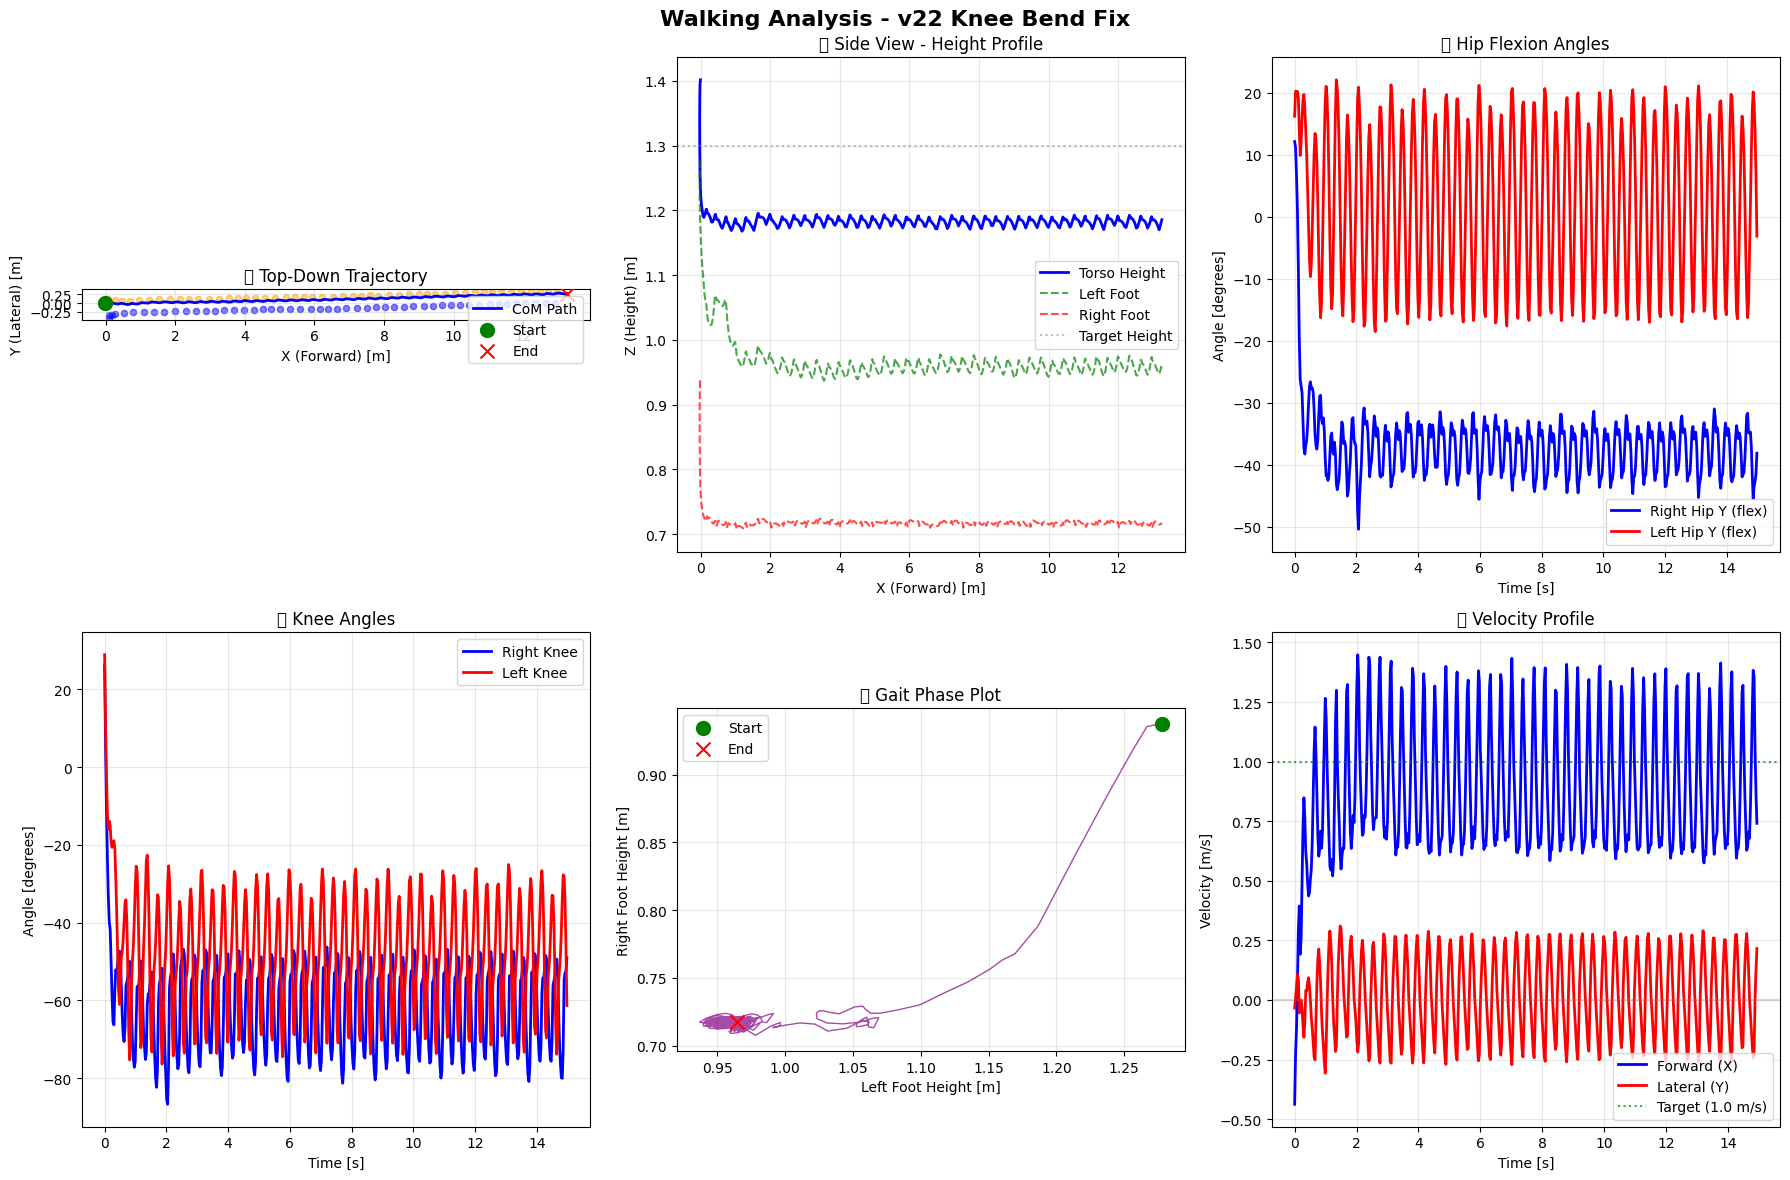

✓ Saved 3D trajectory: /content/braxphysics/RL/Results/walking_3d_v23.png


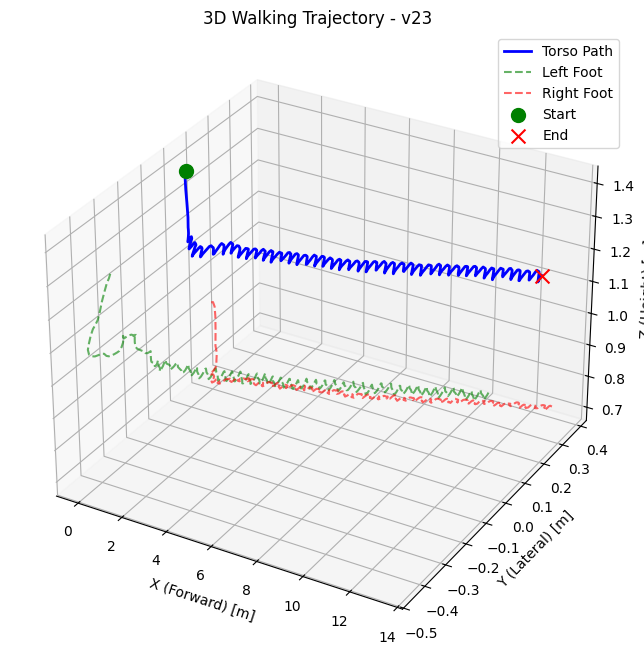


📈 Walking Statistics Summary

  🏃 Distance Traveled: 13.26 m
  ↔️  Lateral Drift: 0.274 m
  📏 Average Height: 1.19 m (target: 1.30 m)
  📊 Height Variation: ±0.020 m
  ⚡ Average Speed: 0.88 m/s (target: 1.0 m/s)

  🦵 Hip Flexion ROM:
     Right: -50.4° to 12.1°
     Left:  -18.5° to 22.1°

  🦿 Knee ROM:
     Right: -86.7° to 26.3°
     Left:  -76.4° to 28.9°

✅ All visualizations saved to Results/ folder!


In [17]:
# Alternative Visualizations for Walking Results

import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
from mpl_toolkits.mplot3d import Axes3D
import numpy as np

print("="*70)
print("📊 Creating Alternative Visualizations for v22")
print("="*70)

# ====== 1. TRAJECTORY PLOTS ======
# Extract data from the recorded states
positions = []
velocities_data = []
joint_angles = []
foot_positions = []
com_positions = []

for state in states:
    # Torso position
    torso_pos = np.array(state.x.pos[0])
    positions.append(torso_pos)

    # Joint angles (legs only)
    joints = np.array(state.q[7:18])
    joint_angles.append(joints)

    # Foot positions
    left_foot = np.array(state.x.pos[8])  # left foot idx
    right_foot = np.array(state.x.pos[5])  # right foot idx
    foot_positions.append((left_foot, right_foot))

positions = np.array(positions)
joint_angles = np.array(joint_angles)

# Create figure with multiple subplots
fig = plt.figure(figsize=(18, 12))
fig.suptitle(f'Walking Analysis - v22 Knee Bend Fix', fontsize=16, fontweight='bold')

# ====== Plot 1: Top-Down Trajectory (Bird's Eye View) ======
ax1 = fig.add_subplot(2, 3, 1)
ax1.plot(positions[:, 0], positions[:, 1], 'b-', linewidth=2, label='CoM Path')
ax1.scatter(positions[0, 0], positions[0, 1], c='green', s=100, marker='o', label='Start', zorder=5)
ax1.scatter(positions[-1, 0], positions[-1, 1], c='red', s=100, marker='x', label='End', zorder=5)

# Plot foot positions every 10 frames
for i in range(0, len(foot_positions), 10):
    lf, rf = foot_positions[i]
    ax1.scatter(lf[0], lf[1], c='blue', s=20, alpha=0.5)
    ax1.scatter(rf[0], rf[1], c='orange', s=20, alpha=0.5)

ax1.set_xlabel('X (Forward) [m]')
ax1.set_ylabel('Y (Lateral) [m]')
ax1.set_title('🗺️ Top-Down Trajectory')
ax1.legend()
ax1.grid(True, alpha=0.3)
ax1.set_aspect('equal')

# ====== Plot 2: Side View (Height over Distance) ======
ax2 = fig.add_subplot(2, 3, 2)
ax2.plot(positions[:, 0], positions[:, 2], 'b-', linewidth=2, label='Torso Height')

# Add foot height traces
left_foot_z = [fp[0][2] for fp in foot_positions]
right_foot_z = [fp[1][2] for fp in foot_positions]
ax2.plot(positions[:, 0], left_foot_z, 'g--', alpha=0.7, label='Left Foot')
ax2.plot(positions[:, 0], right_foot_z, 'r--', alpha=0.7, label='Right Foot')

ax2.axhline(y=1.3, color='gray', linestyle=':', alpha=0.5, label='Target Height')
ax2.set_xlabel('X (Forward) [m]')
ax2.set_ylabel('Z (Height) [m]')
ax2.set_title('📐 Side View - Height Profile')
ax2.legend()
ax2.grid(True, alpha=0.3)

# ====== Plot 3: Hip Joint Angles Over Time ======
ax3 = fig.add_subplot(2, 3, 3)
time = np.arange(len(joint_angles)) * 0.015 * 2  # dt * record_every

ax3.plot(time, np.degrees(joint_angles[:, 5]), 'b-', linewidth=2, label='Right Hip Y (flex)')
ax3.plot(time, np.degrees(joint_angles[:, 9]), 'r-', linewidth=2, label='Left Hip Y (flex)')
ax3.set_xlabel('Time [s]')
ax3.set_ylabel('Angle [degrees]')
ax3.set_title('🦵 Hip Flexion Angles')
ax3.legend()
ax3.grid(True, alpha=0.3)

# ====== Plot 4: Knee Joint Angles Over Time ======
ax4 = fig.add_subplot(2, 3, 4)
ax4.plot(time, np.degrees(joint_angles[:, 6]), 'b-', linewidth=2, label='Right Knee')
ax4.plot(time, np.degrees(joint_angles[:, 10]), 'r-', linewidth=2, label='Left Knee')
ax4.set_xlabel('Time [s]')
ax4.set_ylabel('Angle [degrees]')
ax4.set_title('🦿 Knee Angles')
ax4.legend()
ax4.grid(True, alpha=0.3)

# ====== Plot 5: Foot Height Phase Plot (Gait Cycle) ======
ax5 = fig.add_subplot(2, 3, 5)
ax5.plot(left_foot_z, right_foot_z, 'purple', linewidth=1, alpha=0.7)
ax5.scatter(left_foot_z[0], right_foot_z[0], c='green', s=100, marker='o', label='Start', zorder=5)
ax5.scatter(left_foot_z[-1], right_foot_z[-1], c='red', s=100, marker='x', label='End', zorder=5)
ax5.set_xlabel('Left Foot Height [m]')
ax5.set_ylabel('Right Foot Height [m]')
ax5.set_title('👣 Gait Phase Plot')
ax5.legend()
ax5.grid(True, alpha=0.3)
ax5.set_aspect('equal')

# ====== Plot 6: Velocity Profile ======
ax6 = fig.add_subplot(2, 3, 6)
# Calculate velocity from positions
if len(positions) > 1:
    dt = 0.015 * 2  # timestep * record_every
    vel_x = np.diff(positions[:, 0]) / dt
    vel_y = np.diff(positions[:, 1]) / dt
    time_vel = time[:-1]

    ax6.plot(time_vel, vel_x, 'b-', linewidth=2, label='Forward (X)')
    ax6.plot(time_vel, vel_y, 'r-', linewidth=2, label='Lateral (Y)')
    ax6.axhline(y=1.0, color='green', linestyle=':', alpha=0.7, label='Target (1.0 m/s)')
    ax6.axhline(y=0.0, color='gray', linestyle='-', alpha=0.3)

ax6.set_xlabel('Time [s]')
ax6.set_ylabel('Velocity [m/s]')
ax6.set_title('🏃 Velocity Profile')
ax6.legend()
ax6.grid(True, alpha=0.3)

plt.tight_layout()

# Save the trajectory plot
trajectory_path = f'/content/braxphysics/RL/Results/walking_analysis_{VERSION}.png'
plt.savefig(trajectory_path, dpi=150, bbox_inches='tight')
print(f"✓ Saved trajectory analysis: {trajectory_path}")
plt.show()

# ====== 2. 3D TRAJECTORY VISUALIZATION ======
fig_3d = plt.figure(figsize=(12, 8))
ax_3d = fig_3d.add_subplot(111, projection='3d')

# Plot torso trajectory
ax_3d.plot(positions[:, 0], positions[:, 1], positions[:, 2],
           'b-', linewidth=2, label='Torso Path')

# Plot foot trajectories
left_feet = np.array([fp[0] for fp in foot_positions])
right_feet = np.array([fp[1] for fp in foot_positions])

ax_3d.plot(left_feet[:, 0], left_feet[:, 1], left_feet[:, 2],
           'g--', alpha=0.6, label='Left Foot')
ax_3d.plot(right_feet[:, 0], right_feet[:, 1], right_feet[:, 2],
           'r--', alpha=0.6, label='Right Foot')

# Add start/end markers
ax_3d.scatter(*positions[0], c='green', s=100, marker='o', label='Start')
ax_3d.scatter(*positions[-1], c='red', s=100, marker='x', label='End')

ax_3d.set_xlabel('X (Forward) [m]')
ax_3d.set_ylabel('Y (Lateral) [m]')
ax_3d.set_zlabel('Z (Height) [m]')
ax_3d.set_title(f'3D Walking Trajectory - {VERSION}')
ax_3d.legend()

# Save 3D plot
trajectory_3d_path = f'/content/braxphysics/RL/Results/walking_3d_{VERSION}.png'
plt.savefig(trajectory_3d_path, dpi=150, bbox_inches='tight')
print(f"✓ Saved 3D trajectory: {trajectory_3d_path}")
plt.show()

# ====== 3. SUMMARY STATISTICS ======
print("\n" + "="*70)
print("📈 Walking Statistics Summary")
print("="*70)

total_distance = positions[-1, 0] - positions[0, 0]
lateral_drift = abs(positions[-1, 1] - positions[0, 1])
avg_height = np.mean(positions[:, 2])
height_variation = np.std(positions[:, 2])

print(f"\n  🏃 Distance Traveled: {total_distance:.2f} m")
print(f"  ↔️  Lateral Drift: {lateral_drift:.3f} m")
print(f"  📏 Average Height: {avg_height:.2f} m (target: 1.30 m)")
print(f"  📊 Height Variation: ±{height_variation:.3f} m")

if len(positions) > 1:
    avg_vel = total_distance / (len(positions) * 0.015 * 2)
    print(f"  ⚡ Average Speed: {avg_vel:.2f} m/s (target: 1.0 m/s)")

# Joint range of motion
print(f"\n  🦵 Hip Flexion ROM:")
print(f"     Right: {np.degrees(joint_angles[:, 5].min()):.1f}° to {np.degrees(joint_angles[:, 5].max()):.1f}°")
print(f"     Left:  {np.degrees(joint_angles[:, 9].min()):.1f}° to {np.degrees(joint_angles[:, 9].max()):.1f}°")

print(f"\n  🦿 Knee ROM:")
print(f"     Right: {np.degrees(joint_angles[:, 6].min()):.1f}° to {np.degrees(joint_angles[:, 6].max()):.1f}°")
print(f"     Left:  {np.degrees(joint_angles[:, 10].min()):.1f}° to {np.degrees(joint_angles[:, 10].max()):.1f}°")

print(f"\n✅ All visualizations saved to Results/ folder!")

In [18]:
# High-Quality Video & BVH Export for Portfolio/Blender/Unity

import struct
from pathlib import Path

print("="*70)
print("🎬 High-Quality Video & Animation Export")
print("="*70)

# ====== 1. MP4 VIDEO RENDERING (using Brax's image renderer) ======
print("\n📹 Rendering MP4 Video...")

try:
    from brax.io import image
    import mediapy as media

    # Render video frames from recorded states
    # NOTE: Using 640x480 to fit default framebuffer (max 640 width)
    # For higher resolution, modify the MuJoCo XML with:
    #   <visual><global offwidth="1280" offheight="720"/></visual>

    # Render to frames first (returns list of images)
    print("  Rendering frames...")
    frames = image.render_array(
        mocap_eval_env.sys,
        states,
        width=640,    # Max framebuffer width
        height=480,   # Standard 4:3 aspect
        camera='track'  # Camera follows the robot
    )

    # Save as MP4 using mediapy
    video_path = f'/content/braxphysics/RL/Results/walking_{VERSION}.mp4'
    print(f"  Encoding {len(frames)} frames to MP4...")
    media.write_video(video_path, frames, fps=60)

    print(f"✓ Saved MP4 video: {video_path}")
    print(f"  Resolution: 640x480, Frames: {len(frames)}, FPS: 60")

except Exception as e:
    print(f"⚠ Video rendering failed: {e}")
    print("  (This may require mediapy - try: pip install mediapy)")

# ====== 2. BVH EXPORT (for Blender/Unity/Maya) ======
print("\n🦴 Exporting BVH Animation File...")

def write_bvh_file(filepath, joint_angles, positions, fps=60):
    """
    Export walking animation to BVH format for use in Blender/Unity/Maya.

    BVH (Biovision Hierarchy) is the standard format for motion capture data.
    This can be imported directly into 3D software and retargeted to any humanoid rig.
    """

    # Brax humanoid skeleton hierarchy
    # We'll create a simplified skeleton matching the leg joints

    bvh_content = []

    # ===== HIERARCHY SECTION =====
    bvh_content.append("HIERARCHY")
    bvh_content.append("ROOT Hips")
    bvh_content.append("{")
    bvh_content.append("    OFFSET 0.0 0.0 0.0")
    bvh_content.append("    CHANNELS 6 Xposition Yposition Zposition Zrotation Xrotation Yrotation")

    # Right leg chain
    bvh_content.append("    JOINT RightUpLeg")
    bvh_content.append("    {")
    bvh_content.append("        OFFSET -0.1 0.0 0.0")
    bvh_content.append("        CHANNELS 3 Zrotation Xrotation Yrotation")
    bvh_content.append("        JOINT RightLeg")
    bvh_content.append("        {")
    bvh_content.append("            OFFSET 0.0 -0.45 0.0")
    bvh_content.append("            CHANNELS 1 Xrotation")
    bvh_content.append("            JOINT RightFoot")
    bvh_content.append("            {")
    bvh_content.append("                OFFSET 0.0 -0.45 0.0")
    bvh_content.append("                CHANNELS 0")
    bvh_content.append("                End Site")
    bvh_content.append("                {")
    bvh_content.append("                    OFFSET 0.0 -0.1 0.1")
    bvh_content.append("                }")
    bvh_content.append("            }")
    bvh_content.append("        }")
    bvh_content.append("    }")

    # Left leg chain
    bvh_content.append("    JOINT LeftUpLeg")
    bvh_content.append("    {")
    bvh_content.append("        OFFSET 0.1 0.0 0.0")
    bvh_content.append("        CHANNELS 3 Zrotation Xrotation Yrotation")
    bvh_content.append("        JOINT LeftLeg")
    bvh_content.append("        {")
    bvh_content.append("            OFFSET 0.0 -0.45 0.0")
    bvh_content.append("            CHANNELS 1 Xrotation")
    bvh_content.append("            JOINT LeftFoot")
    bvh_content.append("            {")
    bvh_content.append("                OFFSET 0.0 -0.45 0.0")
    bvh_content.append("                CHANNELS 0")
    bvh_content.append("                End Site")
    bvh_content.append("                {")
    bvh_content.append("                    OFFSET 0.0 -0.1 0.1")
    bvh_content.append("                }")
    bvh_content.append("            }")
    bvh_content.append("        }")
    bvh_content.append("    }")

    # Spine (simplified)
    bvh_content.append("    JOINT Spine")
    bvh_content.append("    {")
    bvh_content.append("        OFFSET 0.0 0.2 0.0")
    bvh_content.append("        CHANNELS 3 Zrotation Xrotation Yrotation")
    bvh_content.append("        End Site")
    bvh_content.append("        {")
    bvh_content.append("            OFFSET 0.0 0.5 0.0")
    bvh_content.append("        }")
    bvh_content.append("    }")

    bvh_content.append("}")

    # ===== MOTION SECTION =====
    num_frames = len(joint_angles)
    frame_time = 1.0 / fps

    bvh_content.append("MOTION")
    bvh_content.append(f"Frames: {num_frames}")
    bvh_content.append(f"Frame Time: {frame_time:.6f}")

    # Write motion data for each frame
    for i in range(num_frames):
        # Root position (convert from Brax coords to BVH coords)
        # BVH: X=right, Y=up, Z=forward
        # Brax: X=forward, Y=left, Z=up
        root_x = -positions[i, 1] * 100  # Brax Y -> BVH -X (cm)
        root_y = positions[i, 2] * 100   # Brax Z -> BVH Y (cm)
        root_z = positions[i, 0] * 100   # Brax X -> BVH Z (cm)

        # Root rotation (simplified - assume upright)
        root_rz, root_rx, root_ry = 0.0, 0.0, 0.0

        # Joint angles (degrees)
        # Right hip: indices 3 (x), 4 (z), 5 (y) in joint_angles
        # Left hip: indices 7 (x), 8 (z), 9 (y)
        # Knees: indices 6 (right), 10 (left)

        r_hip_z = np.degrees(joint_angles[i, 4])   # hip rotation
        r_hip_x = np.degrees(joint_angles[i, 3])   # hip abduction
        r_hip_y = np.degrees(joint_angles[i, 5])   # hip flexion
        r_knee = np.degrees(joint_angles[i, 6])    # knee flexion

        l_hip_z = np.degrees(joint_angles[i, 8])
        l_hip_x = np.degrees(joint_angles[i, 7])
        l_hip_y = np.degrees(joint_angles[i, 9])
        l_knee = np.degrees(joint_angles[i, 10])

        # Spine (abdomen joints)
        spine_z = np.degrees(joint_angles[i, 1])   # twist
        spine_x = np.degrees(joint_angles[i, 2])   # side bend
        spine_y = np.degrees(joint_angles[i, 0])   # forward bend

        # Format: root_pos(3) root_rot(3) r_hip(3) r_knee(1) l_hip(3) l_knee(1) spine(3)
        frame_data = [
            root_x, root_y, root_z,
            root_rz, root_rx, root_ry,
            r_hip_z, r_hip_x, r_hip_y,
            r_knee,
            l_hip_z, l_hip_x, l_hip_y,
            l_knee,
            spine_z, spine_x, spine_y
        ]

        bvh_content.append(" ".join(f"{v:.4f}" for v in frame_data))

    # Write to file
    with open(filepath, 'w') as f:
        f.write("\n".join(bvh_content))

    return num_frames

# Export BVH
bvh_path = f'/content/braxphysics/RL/Results/walking_{VERSION}.bvh'
num_exported_frames = write_bvh_file(bvh_path, joint_angles, positions, fps=60)
print(f"✓ Saved BVH file: {bvh_path}")
print(f"  Frames: {num_exported_frames}, FPS: 60")

# ====== 3. JSON EXPORT (for custom renderers/web) ======
print("\n📄 Exporting JSON Animation Data...")

import json

animation_data = {
    "version": VERSION,
    "fps": 60,
    "num_frames": len(joint_angles),
    "skeleton": {
        "joints": ["hips", "right_hip", "right_knee", "left_hip", "left_knee", "spine"],
        "hierarchy": "hips -> [right_hip -> right_knee, left_hip -> left_knee, spine]"
    },
    "frames": []
}

# Export every frame
for i in range(len(joint_angles)):
    frame = {
        "position": {
            "x": float(positions[i, 0]),
            "y": float(positions[i, 1]),
            "z": float(positions[i, 2])
        },
        "joints": {
            "right_hip_x": float(np.degrees(joint_angles[i, 3])),
            "right_hip_y": float(np.degrees(joint_angles[i, 5])),
            "right_hip_z": float(np.degrees(joint_angles[i, 4])),
            "right_knee": float(np.degrees(joint_angles[i, 6])),
            "left_hip_x": float(np.degrees(joint_angles[i, 7])),
            "left_hip_y": float(np.degrees(joint_angles[i, 9])),
            "left_hip_z": float(np.degrees(joint_angles[i, 8])),
            "left_knee": float(np.degrees(joint_angles[i, 10])),
            "abdomen_y": float(np.degrees(joint_angles[i, 0])),
            "abdomen_z": float(np.degrees(joint_angles[i, 1])),
            "abdomen_x": float(np.degrees(joint_angles[i, 2]))
        }
    }
    animation_data["frames"].append(frame)

json_path = f'/content/braxphysics/RL/Results/walking_{VERSION}.json'
with open(json_path, 'w') as f:
    json.dump(animation_data, f, indent=2)

print(f"✓ Saved JSON file: {json_path}")

# ====== 4. KEYFRAME IMAGE STRIP ======
print("\n🎞️ Creating Keyframe Strip...")

try:
    from brax.io import image as brax_image

    # Select keyframes at regular intervals
    num_keyframes = 8
    keyframe_indices = np.linspace(0, len(states)-1, num_keyframes, dtype=int)
    keyframe_states = [states[i] for i in keyframe_indices]

    # Render each keyframe
    keyframes = []
    for i, kf_state in enumerate(keyframe_states):
        img = brax_image.render(
            mocap_eval_env.sys,
            [kf_state],
            width=320,
            height=240
        )
        keyframes.append(img)

    print(f"✓ Generated {num_keyframes} keyframe images")

except Exception as e:
    print(f"⚠ Keyframe rendering skipped: {e}")

# ====== SUMMARY ======
print("\n" + "="*70)
print("📦 Export Summary")
print("="*70)
print(f"""
  🎬 VIDEO:  walking_{VERSION}.mp4  (640x480)
  🦴 BVH:    walking_{VERSION}.bvh  (Blender/Unity/Maya)
  📄 JSON:   walking_{VERSION}.json (Web/Custom renderers)

  📂 All files saved to: Results/

  🎨 To use in Blender:
     1. File > Import > Motion Capture (.bvh)
     2. Select walking_{VERSION}.bvh
     3. Apply to any humanoid rig (Mixamo, Rigify, etc.)
     4. Render with professional lighting!

  🎮 To use in Unity:
     1. Import the .bvh file
     2. Create a Humanoid Avatar
     3. Apply the animation clip
     4. Retarget to your robot mesh!
""")
print("="*70)

/usr/local/lib/python3.12/dist-packages/glfw/__init__.py:917: GLFWError: (65550) b'X11: The DISPLAY environment variable is missing'
  warnings.warn(message, GLFWError)
/usr/local/lib/python3.12/dist-packages/glfw/__init__.py:917: GLFWError: (65537) b'The GLFW library is not initialized'
  warnings.warn(message, GLFWError)
Exception ignored in: <function Renderer.__del__ at 0x7b960811b1a0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/mujoco/renderer.py", line 340, in __del__
    self.close()
  File "/usr/local/lib/python3.12/dist-packages/mujoco/renderer.py", line 328, in close
    if self._mjr_context:
       ^^^^^^^^^^^^^^^^^
AttributeError: 'Renderer' object has no attribute '_mjr_context'


🎬 High-Quality Video & Animation Export

📹 Rendering MP4 Video...
⚠ Video rendering failed: No module named 'mediapy'
  (This may require mediapy - try: pip install mediapy)

🦴 Exporting BVH Animation File...
✓ Saved BVH file: /content/braxphysics/RL/Results/walking_v23.bvh
  Frames: 500, FPS: 60

📄 Exporting JSON Animation Data...
✓ Saved JSON file: /content/braxphysics/RL/Results/walking_v23.json

🎞️ Creating Keyframe Strip...
⚠ Keyframe rendering skipped: an OpenGL platform library has not been loaded into this process, this most likely means that a valid OpenGL context has not been created before mjr_makeContext was called

📦 Export Summary

  🎬 VIDEO:  walking_v23.mp4  (640x480)
  🦴 BVH:    walking_v23.bvh  (Blender/Unity/Maya)
  📄 JSON:   walking_v23.json (Web/Custom renderers)
  
  📂 All files saved to: Results/
  
  🎨 To use in Blender:
     1. File > Import > Motion Capture (.bvh)
     2. Select walking_v23.bvh
     3. Apply to any humanoid rig (Mixamo, Rigify, etc.)
     4. R

📊 MoCap Training Metrics Summary (v23 - STEP TIMING + POSTURE)
✓ Saved training metrics to '/content/braxphysics/RL/Results/training_metrics_v23.png'


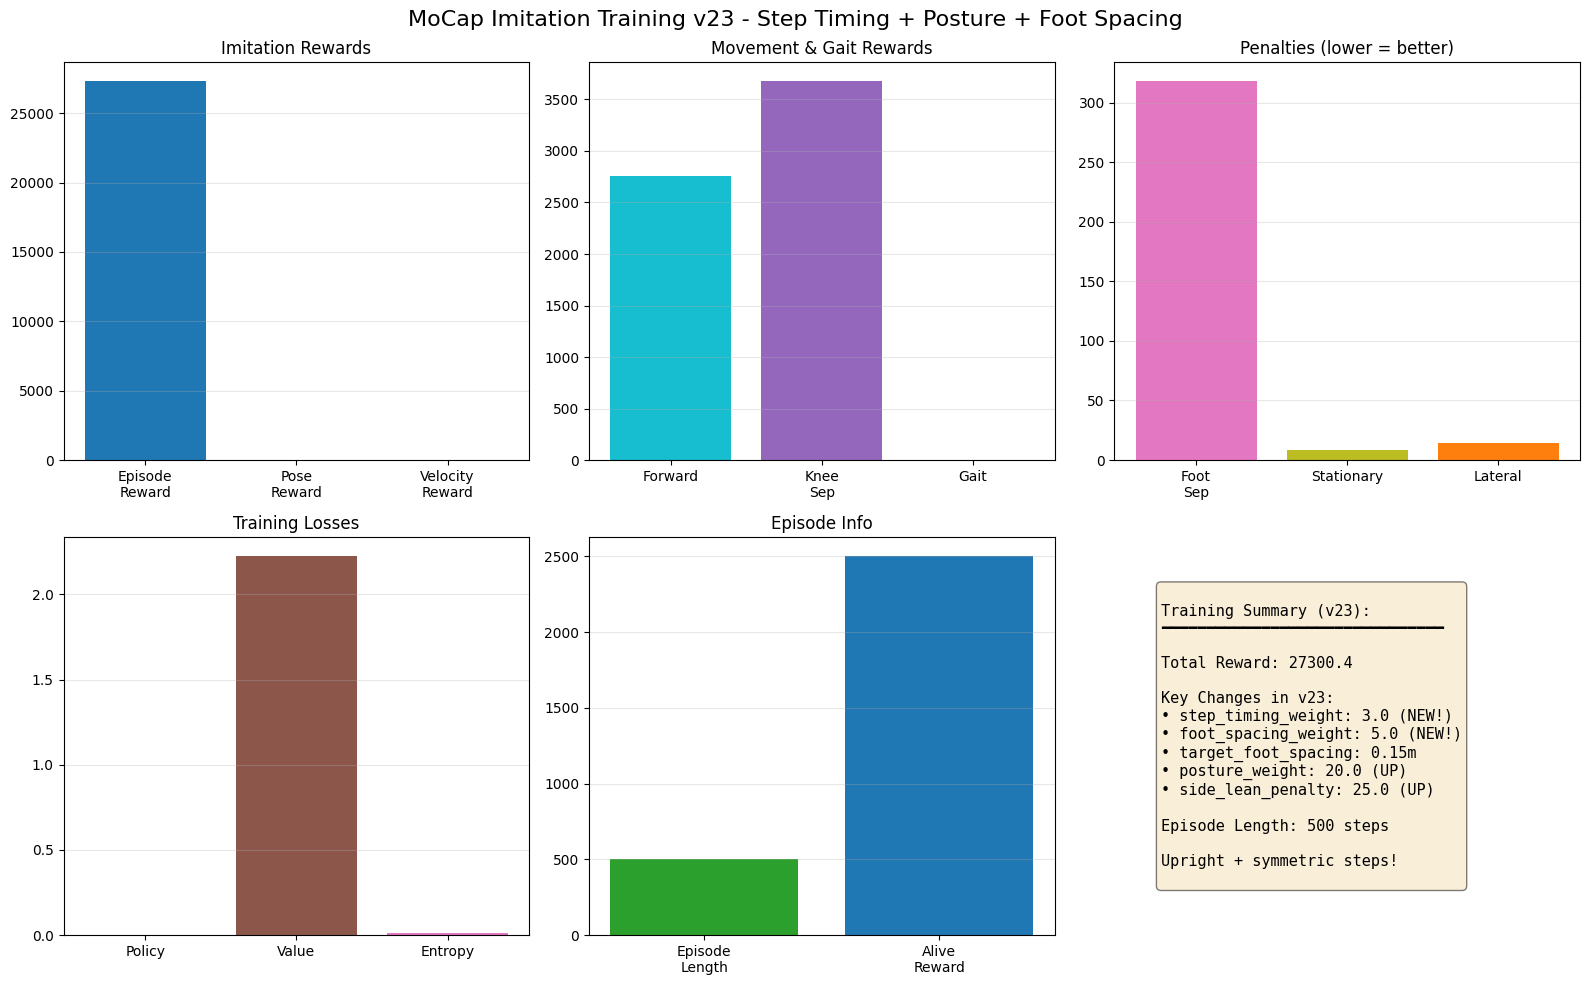

In [19]:
# Plot MoCap Training Metrics (v18 - Step Timing + Posture + Foot Spacing)

import matplotlib.pyplot as plt
import numpy as np

VERSION = "v23"
print(f"📊 MoCap Training Metrics Summary ({VERSION} - STEP TIMING + POSTURE)")

fig, axes = plt.subplots(2, 3, figsize=(16, 10))
fig.suptitle(f'MoCap Imitation Training {VERSION} - Step Timing + Posture + Foot Spacing', fontsize=16)

# Extract scalar metrics
scalar_metrics = {}
for key, values in mocap_metrics.items():
    if hasattr(values, '__array__'):
        values = np.asarray(values)
    if isinstance(values, np.ndarray):
        if values.ndim == 0 or values.size == 1:
            scalar_metrics[key] = float(values)
    else:
        scalar_metrics[key] = values

# Plot 1: Main Imitation Rewards
ax1 = axes[0, 0]
performance = {
    'Episode\nReward': scalar_metrics.get('eval/episode_reward', 0),
    'Pose\nReward': scalar_metrics.get('eval/episode_pose_reward', 0),
    'Velocity\nReward': scalar_metrics.get('eval/episode_velocity_reward', 0),
}
ax1.bar(range(len(performance)), list(performance.values()), color=['#1f77b4', '#2ca02c', '#ff7f0e'])
ax1.set_xticks(range(len(performance)))
ax1.set_xticklabels(list(performance.keys()))
ax1.set_title('Imitation Rewards')
ax1.grid(True, alpha=0.3, axis='y')

# Plot 2: Movement Rewards
ax2 = axes[0, 1]
movement = {
    'Forward': scalar_metrics.get('eval/episode_forward_reward', 0),
    'Knee\nSep': scalar_metrics.get('eval/episode_knee_separation_reward', 0),
    'Gait': scalar_metrics.get('eval/episode_gait_reward', 0),
}
ax2.bar(range(len(movement)), list(movement.values()), color=['#17becf', '#9467bd', '#d62728'])
ax2.set_xticks(range(len(movement)))
ax2.set_xticklabels(list(movement.keys()))
ax2.set_title('Movement & Gait Rewards')
ax2.grid(True, alpha=0.3, axis='y')

# Plot 3: Penalties (should be LOW)
ax3 = axes[0, 2]
penalties = {
    'Foot\nSep': scalar_metrics.get('eval/episode_foot_separation_penalty', 0),
    'Stationary': scalar_metrics.get('eval/episode_stationary_penalty', 0),
    'Lateral': scalar_metrics.get('eval/episode_lateral_penalty', 0),
}
colors = ['#e377c2', '#bcbd22', '#ff7f0e']
ax3.bar(range(len(penalties)), list(penalties.values()), color=colors)
ax3.set_xticks(range(len(penalties)))
ax3.set_xticklabels(list(penalties.keys()))
ax3.set_title('Penalties (lower = better)')
ax3.grid(True, alpha=0.3, axis='y')

# Plot 4: Training Losses
ax4 = axes[1, 0]
losses = {
    'Policy': abs(scalar_metrics.get('training/policy_loss', 0)),
    'Value': scalar_metrics.get('training/v_loss', 0),
    'Entropy': abs(scalar_metrics.get('training/entropy_loss', 0)),
}
ax4.bar(range(len(losses)), list(losses.values()), color=['#ff7f0e', '#8c564b', '#e377c2'])
ax4.set_xticks(range(len(losses)))
ax4.set_xticklabels(list(losses.keys()))
ax4.set_title('Training Losses')
ax4.grid(True, alpha=0.3, axis='y')

# Plot 5: Episode Info
ax5 = axes[1, 1]
episode_info = {
    'Episode\nLength': scalar_metrics.get('eval/avg_episode_length', 0),
    'Alive\nReward': scalar_metrics.get('eval/episode_reward_alive', 0),
}
ax5.bar(range(len(episode_info)), list(episode_info.values()), color=['#2ca02c', '#1f77b4'])
ax5.set_xticks(range(len(episode_info)))
ax5.set_xticklabels(list(episode_info.keys()))
ax5.set_title('Episode Info')
ax5.grid(True, alpha=0.3, axis='y')

# Plot 6: Summary Text
ax6 = axes[1, 2]
ax6.axis('off')
summary_text = f"""
Training Summary ({VERSION}):
━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

Total Reward: {scalar_metrics.get('eval/episode_reward', 0):.1f}

Key Changes in {VERSION}:
• step_timing_weight: 3.0 (NEW!)
• foot_spacing_weight: 5.0 (NEW!)
• target_foot_spacing: 0.15m
• posture_weight: 20.0 (UP)
• side_lean_penalty: 25.0 (UP)

Episode Length: {scalar_metrics.get('eval/avg_episode_length', 0):.0f} steps

Upright + symmetric steps!
"""
ax6.text(0.1, 0.5, summary_text, fontsize=11, family='monospace',
         verticalalignment='center', transform=ax6.transAxes,
         bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))

plt.tight_layout()
metrics_path = f'/content/braxphysics/RL/Results/training_metrics_{VERSION}.png'
plt.savefig(metrics_path, dpi=150)
print(f"✓ Saved training metrics to '{metrics_path}'")

plt.show()